In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import os 
import sys
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import scipy.stats as st
import statsmodels.formula.api as smf
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import time
from collections import OrderedDict
import imageio

%matplotlib inline



# Define some dictionaries for later use

In [3]:
ColorIndex = {"Yellow":"gold","Green":"yellowgreen",
              "Uber":"black","Via":"deepskyblue",
              "Lyft":"magenta","Other":"grey"}
MonthIndex = {1:'January',2:'February',3:'March',4:'April',
              5:'May',6:'June',7:'July',8:'August',9:'September',
              10:'October',11:'November',12:'December'}

# Read in data

In [4]:
# Bring in data
taxigroup = pd.read_csv("TaxiGrouped2015-2017.csv")

# Review
taxigroup.head()

,Unnamed: 0,date,Base,zone,COUNTS
0,0,2015-01-01,uber,Allerton/Pelham Gardens,14
1,1,2015-01-01,uber,Alphabet City,455
2,2,2015-01-01,uber,Arden Heights,1
3,3,2015-01-01,uber,Arrochar/Fort Wadsworth,2
4,4,2015-01-01,uber,Astoria,486


In [5]:
# Change naming conventions in Bases for formatting purposes
taxigroup.replace(['uber','other','lyft', 'via'],
                  ['Uber','Other','Lyft', 'Via'],
                  inplace=True)

# Turn into dates
taxigroup['date'] = pd.to_datetime(taxigroup['date'])

# Clean up the data
taxigroup = taxigroup[(taxigroup['date'].dt.year == 2015) | 
                      (taxigroup['date'].dt.year == 2016) | 
                      (taxigroup['date'].dt.year == 2017)]

# Time series of taxi trips by type

In [6]:
taxis = taxigroup.groupby(('date','Base'))['COUNTS'].sum().reset_index()

<function matplotlib.pyplot.tight_layout>

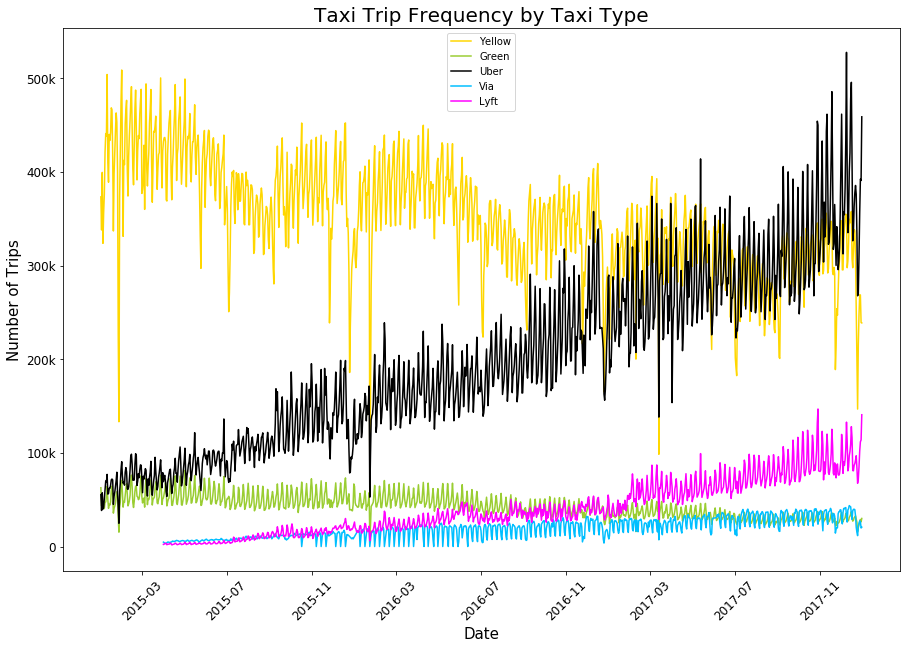

In [7]:
# Set figure
pl.figure(figsize=(15,10))

##############################################################################

# Plot Charts for each base type
pl.plot(taxis[taxis["Base"] == "Yellow"]['date'],
        taxis[taxis["Base"] == "Yellow"]['COUNTS'],color ="gold", 
        label="Yellow")
pl.plot(taxis[taxis["Base"] == "Green"]['date'],
        taxis[taxis["Base"] == "Green"]['COUNTS'],color ="yellowgreen", 
        label="Green")
pl.plot(taxis[taxis["Base"] == "Uber"]['date'],
        taxis[taxis["Base"] == "Uber"]['COUNTS'],color ="black", 
        label="Uber")
pl.plot(taxis[taxis["Base"] == "Via"]['date'],
        taxis[taxis["Base"] == "Via"]['COUNTS'],color ="deepskyblue", 
        label="Via")
pl.plot(taxis[taxis["Base"] == "Lyft"]['date'],
        taxis[taxis["Base"] == "Lyft"]['COUNTS'],color ="magenta", 
        label="Lyft")

##############################################################################

# Format CHart
pl.title("Taxi Trip Frequency by Taxi Type", fontsize=20)
pl.xlabel("Date", fontsize=15)
pl.ylabel("Number of Trips", fontsize=15)
pl.xticks(fontsize=12,rotation=45)
pl.yticks(np.arange(0,600000,100000),('0','100k','200k','300k','400k','500k'), fontsize=12);
# Set legend formats
pl.rc('legend', fontsize=10, markerscale=1)
pl.legend()
pl.tight_layout

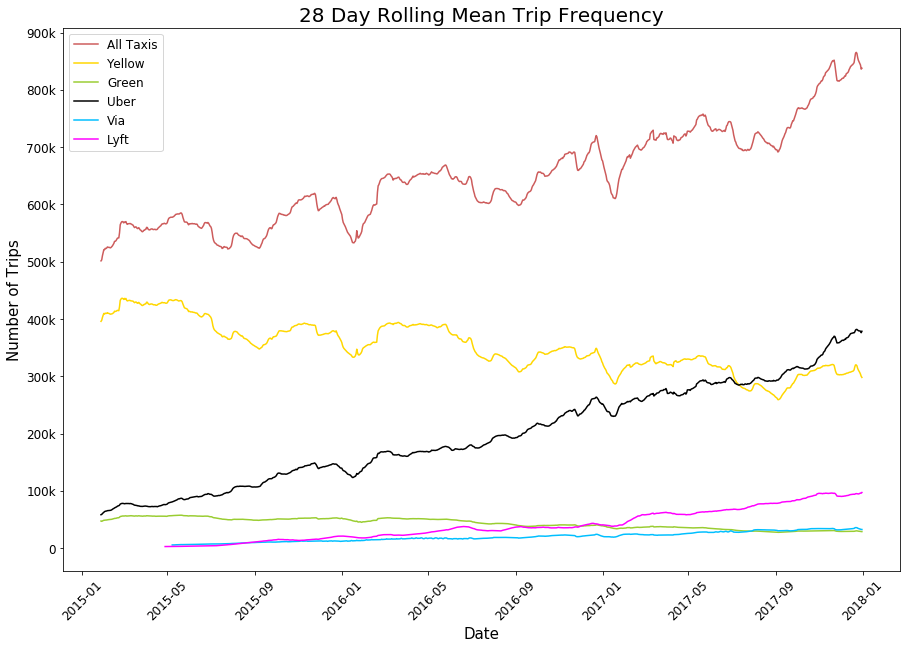

In [70]:
# Set rolling mean period
RollingPeriod = 28

# Set figure
pl.figure(figsize=(15,10))

# Set legend Formats
pl.rc('legend', fontsize=12, markerscale=1)

##############################################################################

AllTaxi = taxis.groupby('date')['COUNTS'].sum()

# Plot Figures
pl.plot(AllTaxi.index,
        AllTaxi.rolling(window=RollingPeriod,center=False).mean(),
        color ="IndianRed", label="All Taxis")

pl.plot(taxis[taxis["Base"] == "Yellow"]['date'],
        taxis[taxis["Base"] == "Yellow"]['COUNTS'].rolling(window=RollingPeriod,
                                                           center=False).mean(),
        color ="gold", label="Yellow")
pl.plot(taxis[taxis["Base"] == "Green"]['date'],
        taxis[taxis["Base"] == "Green"]['COUNTS'].rolling(window=RollingPeriod,
                                                           center=False).mean(),
        color ="yellowgreen", label="Green")
pl.plot(taxis[taxis["Base"] == "Uber"]['date'],
        taxis[taxis["Base"] == "Uber"]['COUNTS'].rolling(window=RollingPeriod,
                                                           center=False).mean(),
        color ="black", label="Uber")
pl.plot(taxis[taxis["Base"] == "Via"]['date'],
        taxis[taxis["Base"] == "Via"]['COUNTS'].rolling(window=RollingPeriod,
                                                           center=False).mean(),
        color ="deepskyblue", label="Via")
pl.plot(taxis[taxis["Base"] == "Lyft"]['date'],
        taxis[taxis["Base"] == "Lyft"]['COUNTS'].rolling(window=RollingPeriod,
                                                           center=False).mean(),
        color ="magenta", label="Lyft")

##############################################################################

# Format CHart
pl.title(str(RollingPeriod) + " Day Rolling Mean Trip Frequency", fontsize=20)
pl.xlabel("Date", fontsize=15)
pl.ylabel("Number of Trips", fontsize=15)
pl.xticks(fontsize=12,rotation=45)
pl.yticks(np.arange(0,1000000,100000),('0','100k','200k','300k','400k','500k','600k','700k','800k','900k'), fontsize=12);
pl.legend()


# Geospatial Analysis

First we need to introduce the taxi zone shape file and then merge onto our grouped data

In [9]:
# Read in taxi zones
taxizones = gpd.read_file("Data/Taxi_Zone_Shapefile/taxi_zones.shp")

In [10]:
# Convert CRS to functional one
taxizones = taxizones.to_crs(epsg=2263)

In [11]:
# Drop redundant columns
taxizones.drop(['OBJECTID','Shape_Leng','Shape_Area'],axis=1,inplace=True)
taxizones.head()

,zone,LocationID,borough,geometry
0,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,..."
1,Jamaica Bay,2,Queens,(POLYGON ((1033269.243591295 172126.0078245894...
2,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506665 256767.6975524619,..."
3,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968614 203714.0760008526,..."
4,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932597 144283.3358627402,..."


In [12]:
# Create year and month data for grouping and organizing
taxigroup["year"] = taxigroup.date.dt.year
taxigroup["month"] = taxigroup.date.dt.month

# Review data
taxigroup.head()

,Unnamed: 0,date,Base,zone,COUNTS,year,month
0,0,2015-01-01,Uber,Allerton/Pelham Gardens,14,2015,1
1,1,2015-01-01,Uber,Alphabet City,455,2015,1
2,2,2015-01-01,Uber,Arden Heights,1,2015,1
3,3,2015-01-01,Uber,Arrochar/Fort Wadsworth,2,2015,1
4,4,2015-01-01,Uber,Astoria,486,2015,1


In [13]:
# Group data into months
MonthlyTaxi = pd.groupby(taxigroup, by=['year',
                                        'month',
                                        'Base',
                                        'zone'])['COUNTS',
                                                 'Base'].sum().reset_index()

# Review data
MonthlyTaxi.head()

C:\Users\Andrew\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
  """


,year,month,Base,zone,COUNTS
0,2015,1,Green,Allerton/Pelham Gardens,245
1,2015,1,Green,Alphabet City,2
2,2015,1,Green,Arden Heights,2
3,2015,1,Green,Arrochar/Fort Wadsworth,14
4,2015,1,Green,Astoria,74203


In [14]:
# Group data into max values
MaxMonthlyTaxi = MonthlyTaxi.groupby(['zone','year',
                                      'month'])['COUNTS'].max().reset_index()

# Remerge Monthly Data to bring back bases
MaxMonthlyTaxi = MonthlyTaxi.merge(MaxMonthlyTaxi, on=['zone',
                                                       'year',
                                                       'month',
                                                       'COUNTS'])

# Review data
MaxMonthlyTaxi[MaxMonthlyTaxi['zone']=='Newark Airport'].head()

,year,month,Base,zone,COUNTS
233,2015,1,Yellow,Newark Airport,689
496,2015,2,Yellow,Newark Airport,701
754,2015,3,Yellow,Newark Airport,797
1015,2015,4,Yellow,Newark Airport,717
1278,2015,5,Yellow,Newark Airport,829


In [15]:
# Merge Data
MaxMonthlyTaxiShape = taxizones.merge(MaxMonthlyTaxi, on="zone")
MaxMonthlyTaxiShape.head()

,zone,LocationID,borough,geometry,year,month,Base,COUNTS
0,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,1,Yellow,689
1,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,2,Yellow,701
2,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,3,Yellow,797
3,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,4,Yellow,717
4,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,5,Yellow,829


In [16]:
# Sort columns for coloring purposes
MaxMonthlyTaxiShape.sort_values(by="Base", inplace=True)

In [17]:
os.system("mkdir images")

1

In [ ]:
# Set legend Formats
pl.rc('legend', fontsize=15, markerscale=1.5)

##############################################################################
for yr in range(2015,2018):
    for mnth in range(1,13):
        # Format Figures and axes
        fig,ax = pl.subplots(figsize=(15,12))
        pl.title("Dominant Taxi Service per Taxi Zone for \n" + str(MonthIndex[mnth]) + 
                 " " + str(yr), fontsize=35)
        ax.set_xticks([])
        ax.set_yticks([])
        
##############################################################################
        # Plot basemap
        taxizones.plot(ax=ax, color='grey')

        # Define color map based on colors present
        cmapin = MaxMonthlyTaxiShape[(MaxMonthlyTaxiShape['year']==yr) & 
                                     (MaxMonthlyTaxiShape['month']==mnth)]['Base'].unique()
        cmap = ListedColormap(map(lambda x: ColorIndex[x], cmapin), name='test')

        MaxMonthlyTaxiShape[(MaxMonthlyTaxiShape['year']==yr) & 
                            (MaxMonthlyTaxiShape['month']==mnth)
                           ].plot(column = "Base", ax=ax, legend=True, 
                                  cmap=cmap,
                                  edgecolor='grey', linewidth=0.3)
            
##############################################################################
        
        # Set legend Formats
        pl.rc('legend', fontsize=15, markerscale=1.5)
    
        fig.savefig("images/DominantTaxibyMonth" + str(yr) + "-" + str(mnth) + ".png")
        
        # For Animation to display
        time.sleep(0.05) # too slow it down
        clear_output(wait=True)
        display(fig)

In [ ]:

with imageio.get_writer('Dominant_Taxi_Service_byMonth.gif', mode='I', duration=0.4) as writer:
    for yr in range(2015,2018):
        for mnth in range(1,13):
            filename = "images/DominantTaxibyMonth" + str(yr) + "-" + str(mnth) + ".png"
            image = imageio.imread(filename)
            writer.append_data(image)

In [41]:
# Group Data 
OverallTaxiDemand = MonthlyTaxi.groupby(('year','month','zone'))['COUNTS'].sum().reset_index()

# Merge Data
OverallTaxiDemandShape = taxizones.merge(OverallTaxiDemand, on="zone")
OverallTaxiDemandShape.head()

,zone,LocationID,borough,geometry,year,month,COUNTS
0,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,1,732
1,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,2,749
2,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,3,841
3,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,4,778
4,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,5,894


In [ ]:
vmin = OverallTaxiDemandShape.COUNTS.min()
vmax = OverallTaxiDemandShape.COUNTS.max()

##############################################################################
for yr in range(2015,2018):
    for mnth in range(1,13):
        fig,ax = pl.subplots(figsize=(15,10))
        pl.title("Overall Taxi Usage per Taxi Zone for \n" + str(MonthIndex[mnth]) + 
                 " " + str(yr), fontsize=30)
        ax.set_xticks([])
        ax.set_yticks([])
        

##############################################################################


        # Plot basemap
        taxizones.plot(ax=ax, color='#440154FF')
        
        OverallTaxiDemandShape[(OverallTaxiDemandShape['year']==yr) & 
                               (OverallTaxiDemandShape['month']==mnth)
                              ].plot(column = "COUNTS", ax=ax, legend=True, 
                                     edgecolor='grey', linewidth=0.3, 
                                     vmin=vmin, vmax=vmax)
            
##############################################################################
        
        pl.ylabel("Number of Trips",rotation=270, fontsize=20)
        ax.yaxis.set_label_coords(1.2, 0.5)
    
        # Set legend Formats
        pl.rc('legend', fontsize=20, markerscale=2)
        
        fig.savefig("images/Taxi_Usage_byZone" + str(yr) + "-" + str(mnth) + ".png")
        
        # For Animation to display
        time.sleep(0.05) # too slow it down
        clear_output(wait=True)
        display(fig)


In [ ]:
with imageio.get_writer('TaxiUsage_byMonth.gif', mode='I', duration=0.2) as writer:
    for yr in range(2015,2018):
        for mnth in range(1,13):
            filename = "images/Taxi_Usage_byZone" + str(yr) + "-" + str(mnth) + ".png"
            image = imageio.imread(filename)
            writer.append_data(image)

In [46]:
# Group Data 
UberTaxiDemand = MonthlyTaxi[MonthlyTaxi['Base']=="Uber"].groupby(('year','month','zone'))['COUNTS'].sum().reset_index()

# Merge Data
OverallTaxiDemandShape = taxizones.merge(OverallTaxiDemand, on="zone")
OverallTaxiDemandShape.head()

,zone,LocationID,borough,geometry,year,month,COUNTS
0,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,1,732
1,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,2,749
2,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,3,841
3,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,4,778
4,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,5,894


In [47]:
# Group Data 
UberTaxiDemand = MonthlyTaxi[MonthlyTaxi['Base']=="Uber"].groupby(('year','month','zone'))['COUNTS'].sum().reset_index()

# Merge Data
UberTaxiDemandShape = taxizones.merge(UberTaxiDemand, on="zone")
UberTaxiDemandShape.head()

,zone,LocationID,borough,geometry,year,month,COUNTS
0,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,1,10
1,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,2,14
2,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,3,14
3,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,4,10
4,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,5,27


In [ ]:
vmin = UberTaxiDemandShape.COUNTS.min()
vmax = UberTaxiDemandShape.COUNTS.max()

vmin = YellowTaxiDemandShape.COUNTS.min()
vmax = YellowTaxiDemandShape.COUNTS.max()

# vmin = OverallTaxiDemandShape.COUNTS.min()
# vmax = OverallTaxiDemandShape.COUNTS.max()

##############################################################################
for yr in range(2015,2018):
    for mnth in range(1,13):
        fig,ax = pl.subplots(figsize=(15,10))
        pl.title("Uber Usage per Taxi Zone for \n" + str(MonthIndex[mnth]) + 
                 " " + str(yr), fontsize=30)
        ax.set_xticks([])
        ax.set_yticks([])
        

##############################################################################


        # Plot basemap
        taxizones.plot(ax=ax, color='#440154FF')
        
        UberTaxiDemandShape[(UberTaxiDemandShape['year']==yr) & 
                               (UberTaxiDemandShape['month']==mnth)
                              ].plot(column = "COUNTS", ax=ax, legend=True, 
                                     edgecolor='grey', linewidth=0.3, 
                                     vmin=vmin, vmax=vmax)
            
##############################################################################
        
        pl.ylabel("Number of Trips",rotation=270, fontsize=20)
        ax.yaxis.set_label_coords(1.2, 0.5)
    
        # Set legend Formats
        pl.rc('legend', fontsize=20, markerscale=2)
        
        fig.savefig("images/Uber_Usage_byZone" + str(yr) + "-" + str(mnth) + ".png")
        
        # For Animation to display
        time.sleep(0.05) # too slow it down
        clear_output(wait=True)
        display(fig)


In [49]:
# Group Data 
YellowTaxiDemand = MonthlyTaxi[MonthlyTaxi['Base']=="Yellow"].groupby(('year','month','zone'))['COUNTS'].sum().reset_index()

# Merge Data
YellowTaxiDemandShape = taxizones.merge(YellowTaxiDemand, on="zone")
YellowTaxiDemandShape.head()

,zone,LocationID,borough,geometry,year,month,COUNTS
0,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,1,689
1,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,2,701
2,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,3,797
3,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,4,717
4,Newark Airport,1,EWR,"POLYGON ((933100.9183527121 192536.0857092953,...",2015,5,829


In [ ]:
vmin = YellowTaxiDemandShape.COUNTS.min()
vmax = YellowTaxiDemandShape.COUNTS.max()

##############################################################################
for yr in range(2015,2018):
    for mnth in range(1,13):
        fig,ax = pl.subplots(figsize=(15,10))
        pl.title("Yellow Taxi Usage per Taxi Zone for \n" + str(MonthIndex[mnth]) + 
                 " " + str(yr), fontsize=30)
        ax.set_xticks([])
        ax.set_yticks([])
        

##############################################################################


        # Plot basemap
        taxizones.plot(ax=ax, color='#440154FF')
        
        YellowTaxiDemandShape[(YellowTaxiDemandShape['year']==yr) & 
                               (YellowTaxiDemandShape['month']==mnth)
                              ].plot(column = "COUNTS", ax=ax, legend=True, 
                                     edgecolor='grey', linewidth=0.3, 
                                     vmin=vmin, vmax=vmax)
            
##############################################################################
        
        pl.ylabel("Number of Trips",rotation=270, fontsize=20)
        ax.yaxis.set_label_coords(1.2, 0.5)
    
        # Set legend Formats
        pl.rc('legend', fontsize=20, markerscale=2)
        
        fig.savefig("images/Yellow_Usage_byZone" + str(yr) + "-" + str(mnth) + ".png")
        
        # For Animation to display
        time.sleep(0.05) # too slow it down
        clear_output(wait=True)
        display(fig)
